# Image Captioning with Vision Transformer (ViT) model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_image_captioning.ipynb)

In this tutorial we implement from scratch and train a transformer-based model on the image captioning task. This task consists of generating a caption text for the input image. We train the model on [Flickr8k](http://hockenmaier.cs.illinois.edu/Framing_Image_Description/KCCA.html) dataset and briefly test trained model on few test images. This tutorial is inspired by ["Image Captioning with Keras"](https://keras.io/examples/vision/image_captioning/).

## Setup

We will be using the following packages in this tutorial:
- [Tiktoken](https://github.com/openai/tiktoken) to tokenize the raw text
- [Grain](https://github.com/google/grain) for efficient data loading and batching
- [tqdm](https://tqdm.github.io/) for a progress bar to monitor the training progress
- HuggingFace [Datasets](https://huggingface.co/docs/datasets/) will be used for dataset provision
- [TorchVision](https://pytorch.org/vision) will be used for image augmentations
- [Matplotlib](https://matplotlib.org/stable/) will be used for visualization purposes

In [1]:
# !pip install -U datasets grain torchvision tqdm transformers matplotlib tiktoken
# !pip install -U flax optax orbax

In [2]:
# Let's use 90% of GPU memory:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

In [3]:
import jax
import flax
import optax
import orbax.checkpoint as ocp
print("Jax version:", jax.__version__)
print("Flax version:", flax.__version__)
print("Optax version:", optax.__version__)
print("Orbax version:", ocp.__version__)

Jax version: 0.4.34
Flax version: 0.10.1
Optax version: 0.2.4
Orbax version: 0.9.1


## Prepare image captioning dataset and dataloaders

In this section we will set up the dataflow for our image captioning task. We will be using [Flickr8k](http://hockenmaier.cs.illinois.edu/Framing_Image_Description/KCCA.html) dataset as a training dataset and download a copy from the [HuggingFace Datasets hub](https://huggingface.co/datasets/clip-benchmark/wds_flickr8k). The dataset contains 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events.

In [4]:
from datasets import load_dataset


dataset_name = "clip-benchmark/wds_flickr8k"
train_dataset = load_dataset(dataset_name, split="train")
test_dataset = load_dataset(dataset_name, split="test")

# Remap datapoint key names
def remap_keys(data):
    return {
        "image": data["jpg"],
        "caption": data["txt"],
    }

train_dataset = train_dataset.with_transform(remap_keys)
test_dataset = test_dataset.with_transform(remap_keys)


print("Training dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Training dataset size: 6000
Test dataset size: 1000


In [5]:
import matplotlib.pyplot as plt


def display_datapoints(*datapoints, tag=""):
    num_samples = len(datapoints)

    fig, axs = plt.subplots(1, num_samples, figsize=(20, 10))
    for i, datapoint in enumerate(datapoints):
        if isinstance(datapoint, dict):
            img, captions = datapoint["image"], datapoint["caption"]
        else:
            img, captions = datapoint

        if hasattr(img, "dtype") and img.dtype in (np.float32, ):
            img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)

        if isinstance(captions, str):
            cap_str = "\n".join([cap for cap in captions.split("\n")])
        else:
            cap_str = f"tensor shape: {captions.shape}\n{captions[:5]}..."
        axs[i].set_title(f"{tag}Caption:\n{cap_str}")
        axs[i].imshow(img)

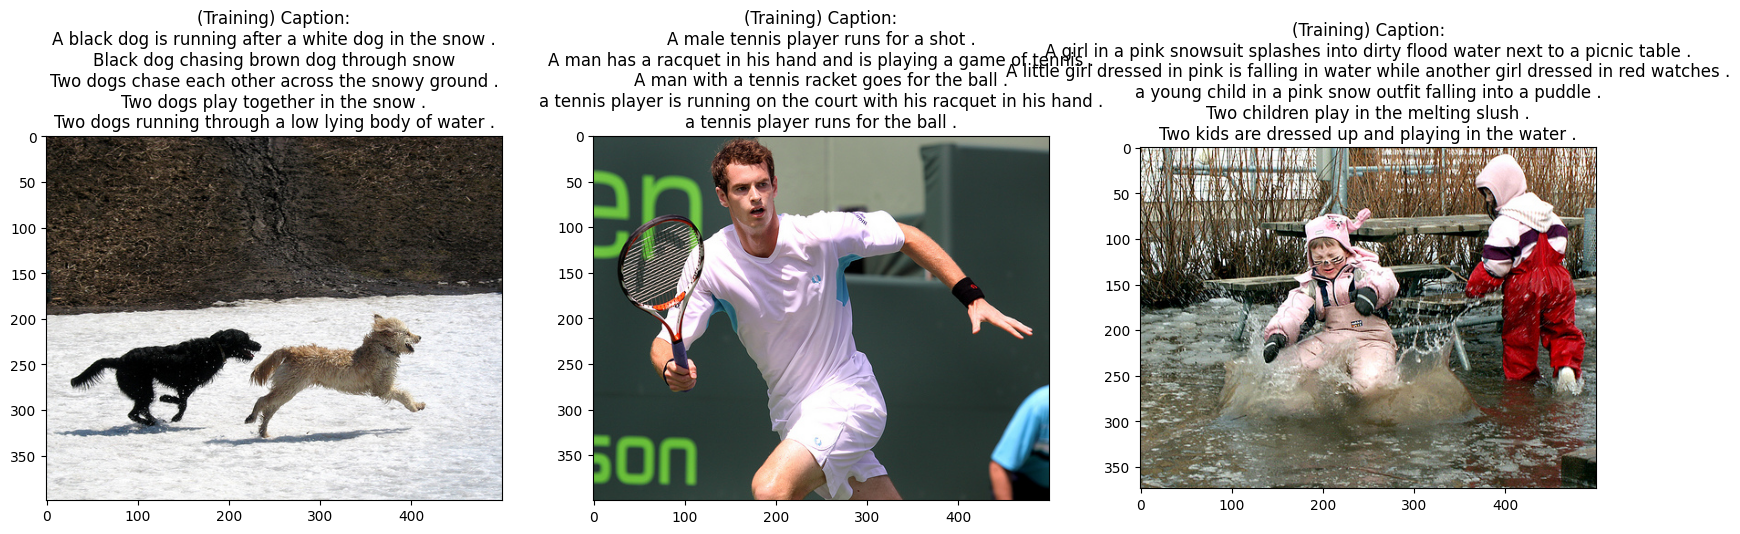

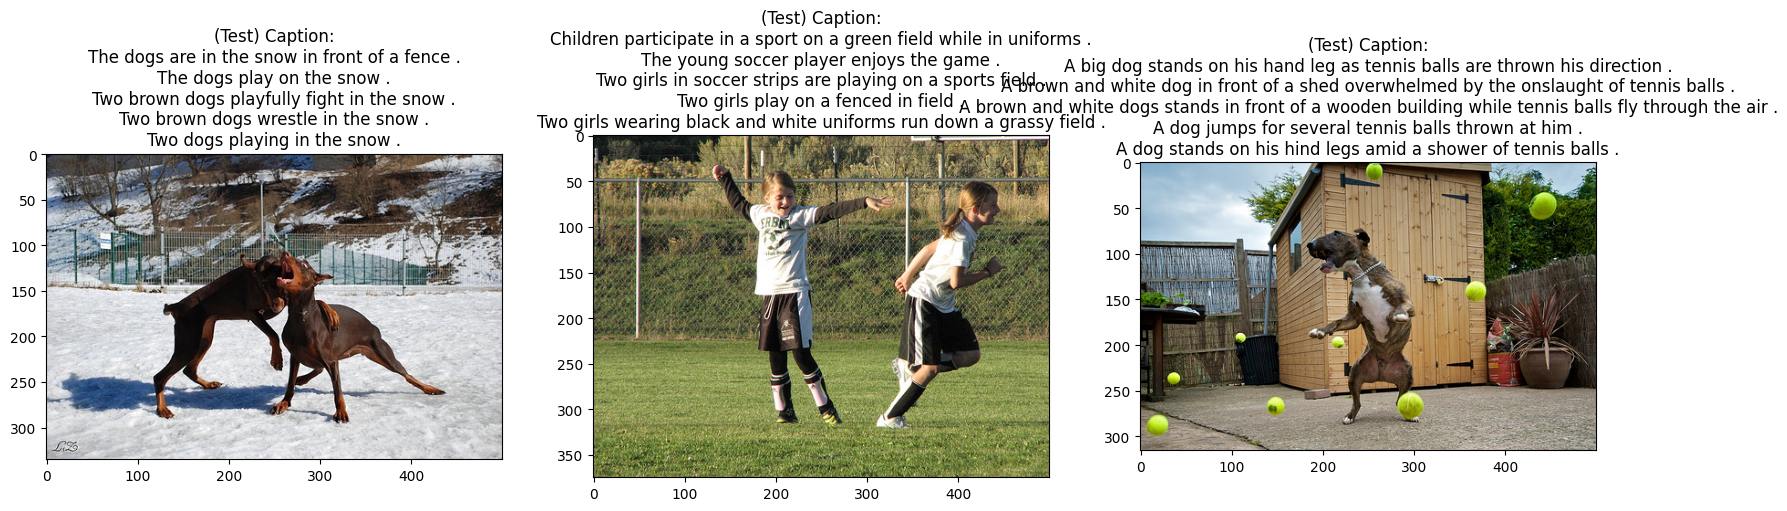

In [6]:
display_datapoints(
    train_dataset[0], train_dataset[1000], train_dataset[2000],
    tag="(Training) ",
)

display_datapoints(
    test_dataset[0], test_dataset[500], test_dataset[-1],
    tag="(Test) ",
)

Below we define image and text transformations. We will be using [TorchVision](https://pytorch.org/vision) to transform input images. Training image transformations will also contain random augmentations to prevent overfitting and make trained model more robust. For the captions we pick the longest caption among 5 captions and we are going to use the GPT-2 tokenizer via [Tiktoken](https://github.com/openai/tiktoken) to make a string-to-tokens preprocessing transformation: text string into integer tensors.

In [7]:
import grain.python as grain
import numpy as np
import tiktoken
from torchvision.transforms import v2 as T


seed = 12
train_batch_size = 196
test_batch_size = 2 * train_batch_size
img_size = 224
max_length = 150

tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer.n_vocab


def to_np_array(pil_image):
  return np.asarray(pil_image.convert("RGB"))


def normalize(image):
    # We use here the normalization parameters matching
    # pretrained ViT from HF Transformers:
    # ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
    mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    std = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    image = image.astype(np.float32) / 255.0
    return (image - mean) / std


train_transforms = T.Compose([
    T.RandomResizedCrop((img_size, img_size), scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2, 0.2, 0.2),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


test_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])

Finally, using [`grain`](https://github.com/google/grain/) we put all transformations into `grain.MapTransform` and create dataloaders for efficient data loading.

In [8]:
import string


class ImageTransforms(grain.MapTransform):
    def __init__(self, tv_transforms: callable):
        self.tv_transforms = tv_transforms

    def map(self, data):
        image = data["image"]
        output = self.tv_transforms(image)
        return {
            "image": output,
            "caption": data["caption"]
        }

start_tag = "[start]"
end_tag = "[end]"


class TextPreprocessing(grain.MapTransform):
    def __init__(self, tokenizer, max_length: int = 256, use_longest_caption: bool = False):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self._str_trans_table = str.maketrans("", "", string.punctuation)
        self.use_longest_caption = use_longest_caption

    def map(self, data):
        # We remove all punctuation chars using s.translate()
        captions = [cap.translate(self._str_trans_table).strip() for cap in data["caption"].split("\n")]
        if self.use_longest_caption:
            # Use the longest caption
            longest_caption = sorted(captions, key=lambda x: len(x))[-1]
            text = start_tag + longest_caption + end_tag
        else:
            # Let's join all captions as:
            # start_tag + cap1 + eng_tag + start_tag + cap2 + eng_tag + ... + start_tag + cap5 + eng_tag
            text_list = []
            for cap in captions:
                text_list += [start_tag, cap, end_tag, " "]
            text = "".join(text_list)

        encoded = self.tokenizer.encode(
            text, allowed_special={start_tag, end_tag}
        )
        # Cut to max length
        encoded = encoded[:self.max_length]
        # Pad with zeros if needed
        encoded = np.array(encoded + [0] * (self.max_length - len(encoded)))
        return {
            "caption": encoded,
            "image": data["image"],
        }


train_sampler = grain.IndexSampler(
    len(train_dataset),
    shuffle=True,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)

test_sampler = grain.IndexSampler(
    len(test_dataset),
    shuffle=False,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)


train_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,                 # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker
    operations=[
        ImageTransforms(train_transforms),
        TextPreprocessing(tokenizer, max_length=max_length),
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

test_loader = grain.DataLoader(
    data_source=test_dataset,
    sampler=test_sampler,                  # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker
    operations=[
        ImageTransforms(test_transforms),
        TextPreprocessing(tokenizer, max_length=max_length),
        grain.Batch(test_batch_size),
    ]
)

Let's visualize training and validation batches

In [9]:
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))

In [10]:
print("Training batch info:", train_batch["image"].shape, train_batch["image"].dtype, train_batch["caption"].shape, train_batch["caption"].dtype)
print("Test batch info:", test_batch["image"].shape, test_batch["image"].dtype, test_batch["caption"].shape, test_batch["caption"].dtype)

Training batch info: (196, 224, 224, 3) float32 (196, 150) int64
Test batch info: (250, 224, 224, 3) float32 (250, 150) int64


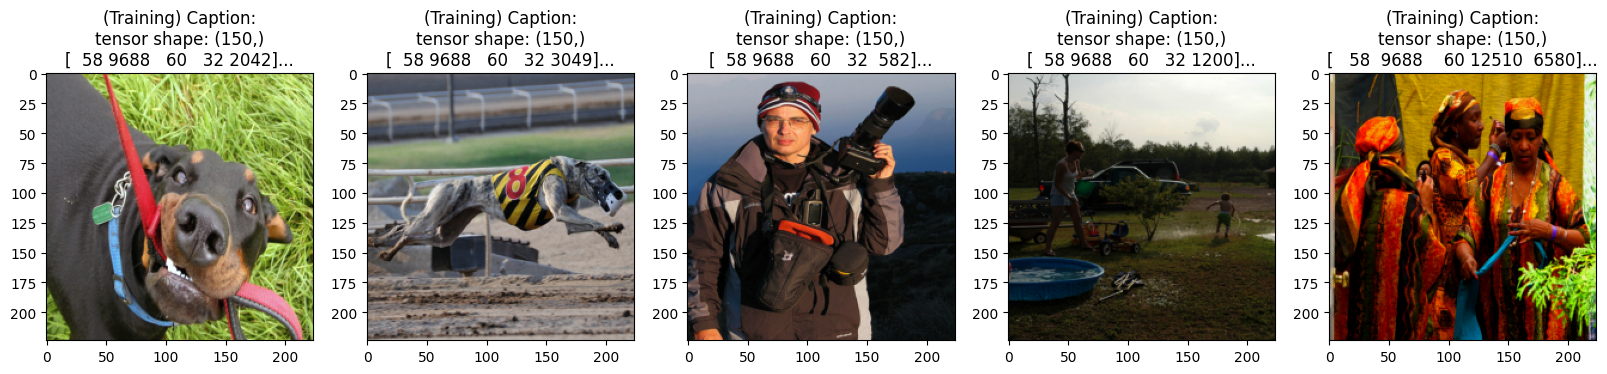

In [11]:
display_datapoints(
    *[(train_batch["image"][i], train_batch["caption"][i]) for i in range(5)],
    tag="(Training) ",
)

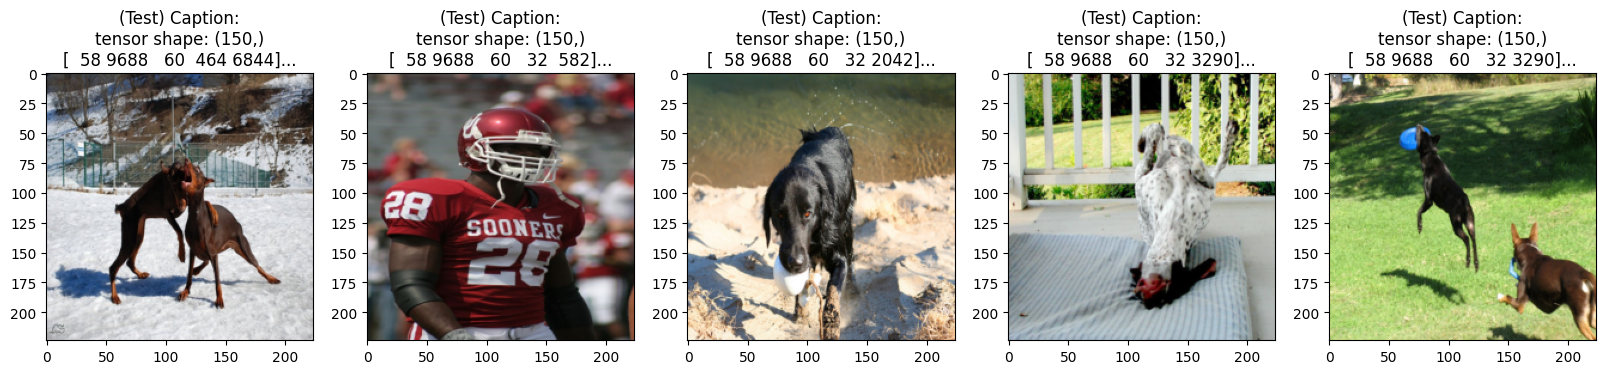

In [12]:
display_datapoints(
    *[(test_batch["image"][i], test_batch["caption"][i]) for i in range(5)],
    tag="(Test) ",
)

Let's take a closer look at encoded and decoded captions:

In [13]:
cap = train_batch["caption"][0, :]
print("Encoded caption:", cap)
print("Decoded caption:", tokenizer.decode(cap))

Encoded caption: [   58  9688    60    32  2042   290  7586  6844 10427   257  2266 40529
    58   437    60   685  9688    60    32  2042  3290 36615   319   257
  2266 40529    58   437    60   685  9688    60    32  3290  1125 18504
   319   465  2266 40529    58   437    60   685  9688    60    32  3290
   286  3223  3124  6622   257  2266 40529   287   465  5422    58   437
    60   685  9688    60    64  3290   256 10339   319   465  2266 40529
    58   437    60   220     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
Decoded caption: [start]A black and brown dogs pulling a red leash[en

## Model

We implement from scratch a transformer-based model for the image captioning task. The model contains two part:
- transformer encoder ([Vision Transformer](https://arxiv.org/abs/2010.11929) pretrained on the ImageNet): it takes input image and returns a sequence of tokens corresponding to the input image.
- transformer decoder: it takes two inputs: 1) the encoder output: a sequence of image tokens, 2) a sequence of caption tokens, a context, and returns the new sequence caption tokens containing previous tokens and one generated next token.

### Pretrained Vision Transformer

Below we implement from scratch Vision Transformer (ViT) model based on the paper by Dosovitskiy et al: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929). We add an additional flag to skip the classification head and return the sequence of image tokens.

In [14]:
import jax.numpy as jnp
from flax import nnx


class VisionTransformer(nnx.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        in_channels: int = 3,
        img_size: int = 224,
        patch_size: int = 16,
        num_layers: int = 12,
        num_heads: int = 12,
        mlp_dim: int = 3072,
        hidden_size: int = 768,
        dropout_rate: float = 0.1,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
        include_top: bool = True
    ):
        # Patch and position embedding
        n_patches = (img_size // patch_size) ** 2
        self.patch_embeddings = nnx.Conv(
            in_channels,
            hidden_size,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            use_bias=True,
            rngs=rngs,
        )

        initializer = jax.nn.initializers.truncated_normal(stddev=0.02)
        self.position_embeddings = nnx.Param(
            initializer(rngs.params(), (1, n_patches + 1, hidden_size), jnp.float32)
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)

        self.cls_token = nnx.Param(jnp.zeros((1, 1, hidden_size)))

        # Transformer Encoder blocks
        self.encoder = nnx.Sequential(*[
            TransformerEncoder(hidden_size, mlp_dim, num_heads, dropout_rate, rngs=rngs)
            for i in range(num_layers)
        ])
        self.final_norm = nnx.LayerNorm(hidden_size, rngs=rngs)

        self.include_top = include_top
        # Classification head
        self.classifier = nnx.Linear(hidden_size, num_classes, rngs=rngs)

        # store config info:
        self.hidden_size = hidden_size
        self.mlp_dim = mlp_dim
        self.img_size = img_size
        self.patch_size = patch_size

    def __call__(self, x: jax.Array) -> jax.Array:
        # Patch and position embedding
        patches = self.patch_embeddings(x)
        batch_size = patches.shape[0]
        patches = patches.reshape(batch_size, -1, patches.shape[-1])

        cls_token = jnp.tile(self.cls_token, [batch_size, 1, 1])
        x = jnp.concat([cls_token, patches], axis=1)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)

        # Encoder blocks
        x = self.encoder(embeddings)
        x = self.final_norm(x)

        if self.include_top:
            # fetch the first token
            x = x[:, 0]

            # Classification
            return self.classifier(x)
        else:
            return x


class TransformerEncoder(nnx.Module):
    def __init__(
        self,
        hidden_size: int,
        mlp_dim: int,
        num_heads: int,
        dropout_rate: float = 0.0,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ) -> None:

        self.norm1 = nnx.LayerNorm(hidden_size, rngs=rngs)
        self.attn = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=hidden_size,
            dropout_rate=dropout_rate,
            broadcast_dropout=False,
            decode=False,
            deterministic=False,
            rngs=rngs,
        )
        self.norm2 = nnx.LayerNorm(hidden_size, rngs=rngs)

        self.mlp = nnx.Sequential(
            nnx.Linear(hidden_size, mlp_dim, rngs=rngs),
            nnx.gelu,
            nnx.Dropout(dropout_rate, rngs=rngs),
            nnx.Linear(mlp_dim, hidden_size, rngs=rngs),
            nnx.Dropout(dropout_rate, rngs=rngs),
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


# We use a configuration to make smaller model to reduce the training time
x = jnp.ones((4, 224, 224, 3))
model = VisionTransformer(num_classes=1000)
y = model(x)
print("Predictions shape: ", y.shape)


params = nnx.state(model, nnx.Param)
print("Number of model parameters: ", sum([p.size for p in jax.tree.flatten(params)[0]]))

Predictions shape:  (4, 1000)
Number of model parameters:  86567656


Let's now load the weights pretrained on the ImageNet dataset using HuggingFace Transformers

In [15]:
from transformers import FlaxViTForImageClassification

tf_model = FlaxViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [16]:
def vit_inplace_copy_weights(*, src_model, dst_model):
    assert isinstance(src_model, FlaxViTForImageClassification)
    assert isinstance(dst_model, VisionTransformer)

    tf_model_params = src_model.params
    tf_model_params_fstate = nnx.traversals.flatten_mapping(tf_model_params)

    flax_model_params = nnx.state(dst_model, nnx.Param)
    flax_model_params_fstate = dict(flax_model_params.flat_state())

    src_num_params = sum([p.size for p in tf_model_params_fstate.values()])
    dst_num_params = sum([p.value.size for p in flax_model_params_fstate.values()])
    assert src_num_params == dst_num_params

    params_name_mapping = {
        **{
            ("classifier", x): ("classifier", x)
            for x in ["kernel", "bias"]
        },
        ("cls_token",): ("vit", "embeddings", "cls_token"),
        ("position_embeddings",): ("vit", "embeddings", "position_embeddings"),
        **{
            ("patch_embeddings", x): ("vit", "embeddings", "patch_embeddings", "projection", x)
            for x in ["kernel", "bias"]
        },
        **{
            ("encoder", "layers", i, "attn", y, x): (
                "vit", "encoder", "layer", str(i), "attention", "attention", y, x
            )
            for x in ["kernel", "bias"]
            for y in ["key", "value", "query"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "attn", "out", x): (
                "vit", "encoder", "layer", str(i), "attention", "output", "dense", x
            )
            for x in ["kernel", "bias"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "mlp", "layers", y1, x): (
                "vit", "encoder", "layer", str(i), y2, "dense", x
            )
            for x in ["kernel", "bias"]
            for y1, y2 in [(0, "intermediate"), (3, "output")]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, y1, x): (
                "vit", "encoder", "layer", str(i), y2, x
            )
            for x in ["scale", "bias"]
            for y1, y2 in [("norm1", "layernorm_before"), ("norm2", "layernorm_after")]
            for i in range(12)
        },
        **{
            ("final_norm", x): ("vit", "layernorm", x)
            for x in ["scale", "bias"]
        }
    }

    nonvisited = set(flax_model_params_fstate.keys())

    for key1, key2 in params_name_mapping.items():
        assert key1 in flax_model_params_fstate, key1
        assert key2 in tf_model_params_fstate, (key1, key2)

        nonvisited.remove(key1)

        src_value = tf_model_params_fstate[key2]
        if key2[-1] == "kernel" and key2[-2] in ("key", "value", "query"):
            shape = src_value.shape
            src_value = src_value.reshape((shape[0], 12, 64))

        if key2[-1] == "bias" and key2[-2] in ("key", "value", "query"):
            src_value = src_value.reshape((12, 64))

        if key2[-4:] == ("attention", "output", "dense", "kernel"):
            shape = src_value.shape
            src_value = src_value.reshape((12, 64, shape[-1]))

        dst_value = flax_model_params_fstate[key1]
        assert src_value.shape == dst_value.value.shape, (key2, src_value.shape, key1, dst_value.value.shape)
        dst_value.value = src_value.copy()
        assert dst_value.value.mean() == src_value.mean(), (dst_value.value, src_value.mean())

    assert len(nonvisited) == 0, nonvisited
    nnx.update(dst_model, nnx.State.from_flat_path(flax_model_params_fstate))


vit_inplace_copy_weights(src_model=tf_model, dst_model=model)

Let's check the pretrained weights of our model and compare with the reference model results

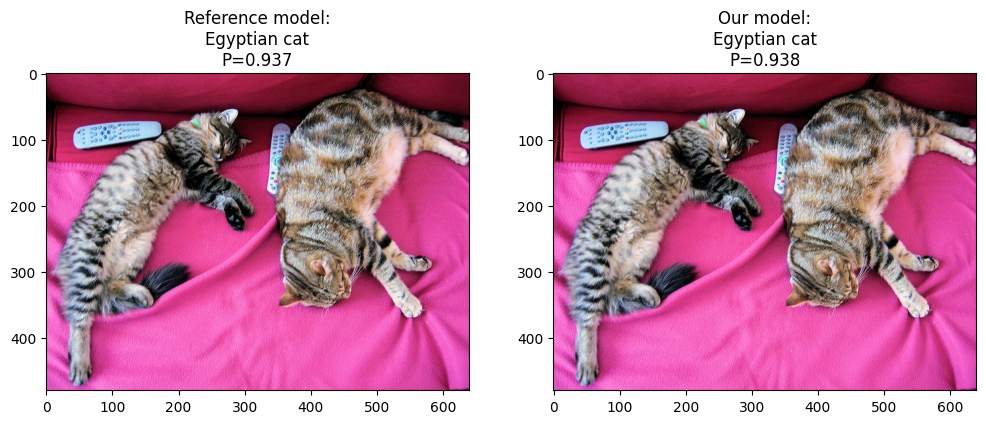

In [17]:
from transformers import ViTImageProcessor
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="np")
outputs = tf_model(**inputs)
logits = outputs.logits


model.eval()
x = jnp.transpose(inputs["pixel_values"], axes=(0, 2, 3, 1))
output = model(x)

# model predicts one of the 1000 ImageNet classes
ref_class_idx = logits.argmax(-1).item()
pred_class_idx = output.argmax(-1).item()
assert jnp.abs(logits[0, :] - output[0, :]).max() < 0.1

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].set_title(
    f"Reference model:\n{tf_model.config.id2label[ref_class_idx]}\nP={nnx.softmax(logits, axis=-1)[0, ref_class_idx]:.3f}"
)
axs[0].imshow(image)
axs[1].set_title(
    f"Our model:\n{tf_model.config.id2label[pred_class_idx]}\nP={nnx.softmax(output, axis=-1)[0, pred_class_idx]:.3f}"
)
axs[1].imshow(image)

However, for the image captioning task we need ViT model to return the sequence of tokens before the classification head:

In [18]:
def get_vit_encoder(
    img_size: int = 224,
    patch_size: int = 16,
    num_layers: int = 12,
    num_heads: int = 12,
    mlp_dim: int = 3072,
    hidden_size: int = 768,
    dropout_rate: float = 0.1,
    *,
    rngs: nnx.Rngs = nnx.Rngs(0),
    use_pretained_weights: bool = True,
):
    encoder = VisionTransformer(
        num_classes=1000,
        img_size=img_size,
        patch_size=patch_size,
        num_layers=num_layers,
        num_heads=num_heads,
        mlp_dim=mlp_dim,
        hidden_size=hidden_size,
        dropout_rate=dropout_rate,
        rngs=rngs,
    )
    if use_pretained_weights:
        tf_model = FlaxViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
        vit_inplace_copy_weights(src_model=tf_model, dst_model=encoder)

    encoder.include_top = False
    return encoder


encoder = get_vit_encoder()
encoder.eval()
x = jnp.ones((4, 224, 224, 3))
y = encoder(x)
print("Image encoded sequence:", y.shape)

Image encoded sequence: (4, 197, 768)


In [19]:
del model, encoder, tf_model

### Transformer decoder

In [20]:
def causal_attention_mask(sequence_length):
    return jnp.tril(jnp.ones((sequence_length, sequence_length)))


class PositionalEmbedding(nnx.Module):
    def __init__(
        self,
        sequence_length: int,
        vocab_size: int,
        hidden_size: int = 768,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.token_embeddings = nnx.Embed(
            num_embeddings=vocab_size, features=hidden_size, rngs=rngs
        )
        self.position_embeddings = nnx.Embed(
            num_embeddings=sequence_length, features=hidden_size, rngs=rngs
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        sequence_length = x.shape[1]
        positions = jnp.arange(0, sequence_length)[None, :]
        embedded_tokens = self.token_embeddings(x)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions


class TransformerDecoderLayer(nnx.Module):
    def __init__(
        self,
        num_heads: int = 12,
        mlp_dim: int = 3072,
        hidden_size: int = 768,
        dropout_rate: float = 0.1,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.masked_self_mha = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=hidden_size,
            broadcast_dropout=False,
            decode=False,
            deterministic=False,
            rngs=rngs,
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
        self.norm1 = nnx.LayerNorm(num_features=hidden_size, rngs=rngs)

        self.encoder_mha = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=hidden_size,
            broadcast_dropout=False,
            decode=False,
            deterministic=False,
            rngs=rngs,
        )
        self.norm2 = nnx.LayerNorm(num_features=hidden_size, rngs=rngs)

        self.mlp = nnx.Sequential(
            nnx.Linear(hidden_size, mlp_dim, rngs=rngs),
            nnx.gelu,
            nnx.Dropout(dropout_rate, rngs=rngs),
            nnx.Linear(mlp_dim, hidden_size, rngs=rngs),
            nnx.Dropout(dropout_rate, rngs=rngs),
        )
        self.norm3 = nnx.LayerNorm(num_features=hidden_size, rngs=rngs)

    def __call__(
        self, decoder_input: jax.Array, encoder_output: jax.Array, mask: jax.Array | None = None
    ) -> jax.Array:
        # Self-attention part on decoder input
        causal_mask = causal_attention_mask(decoder_input.shape[1])  # (sequence_length, sequence_length)

        if mask is not None:
            # mask shape: (N, sequence_length)
            padding_mask = mask[:, None, :, None].astype("int32")  # (N, 1, sequence_length, 1)
            combined_mask = mask[:, None, None, :].astype("int32")  # (N, 1, sequence_length)
            combined_mask = jnp.minimum(combined_mask, causal_mask)  # (N, 1, sequence_length, sequence_length)
        else:
            combined_mask = causal_mask
            padding_mask = None

        attention_output = self.masked_self_mha(inputs_q=decoder_input, mask=combined_mask)
        attention_output = self.dropout(attention_output)
        attention_output = self.norm1(decoder_input + attention_output)

        # Attention part on encoder input
        decoder_output = self.encoder_mha(
            inputs_q=attention_output,
            inputs_v=encoder_output,
            inputs_k=encoder_output,
            mask=padding_mask,
        )
        decoder_output = self.dropout(decoder_output)
        decoder_output = self.norm2(decoder_output + attention_output)

        # Final MLP part
        decoder_output = decoder_output + self.mlp(decoder_output)
        decoder_output = self.norm3(decoder_output)

        return decoder_output


class TransformerDecoder(nnx.Module):
    def __init__(
        self,
        sequence_length: int,
        vocab_size: int,
        num_layers: int = 12,
        num_heads: int = 12,
        mlp_dim: int = 3072,
        hidden_size: int = 768,
        dropout_rate: float = 0.1,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.positional_embedding = PositionalEmbedding(
            sequence_length, vocab_size, hidden_size, rngs=rngs
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
        self.decoder_blocks =  [
            TransformerDecoderLayer(
                num_heads, mlp_dim, hidden_size, dropout_rate=dropout_rate
            )
            for _ in range(num_layers)
        ]

    def __call__(
        self, decoder_input: jax.Array, encoder_output: jax.Array, mask: jax.Array | None = None
    ) -> jax.Array:

        x = self.positional_embedding(decoder_input)
        x = self.dropout(x)

        for layer in self.decoder_blocks:
            x = layer(x, encoder_output, mask=mask)

        return x

### Image Captioning Model

In [23]:
class ImageCaptioningModel(nnx.Module):
    def __init__(
        self,
        # encoder config:
        img_size: int = 224,
        patch_size: int = 16,
        encoder_num_layers: int = 12,
        encoder_num_heads: int = 12,
        encoder_mlp_dim: int = 3072,
        use_pretained_encoder: bool = True,
        # decoder config:
        vocab_size: int = 50257,
        decoder_sequence_length: int = 50,
        decoder_num_layers: int = 4,
        decoder_num_heads: int = 6,
        decoder_mlp_dim: int = 3072,
        # other common config:
        dropout_rate: float = 0.1,
        hidden_size: int = 768,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),

    ):
        self.encoder = get_vit_encoder(
            img_size,
            patch_size,
            encoder_num_layers,
            encoder_num_heads,
            encoder_mlp_dim,
            hidden_size,
            dropout_rate=dropout_rate,
            use_pretained_weights=use_pretained_encoder,
            rngs=rngs,
        )
        self.decoder = TransformerDecoder(
            decoder_sequence_length,
            vocab_size,
            decoder_num_layers,
            decoder_num_heads,
            decoder_mlp_dim,
            hidden_size,
            dropout_rate=dropout_rate,
            rngs=rngs,
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
        self.lm_head = nnx.Linear(hidden_size, vocab_size, rngs=rngs)

    def __call__(
        self, img: jax.Array, decoder_input: jax.Array, mask: jax.Array | None = None
    ) -> jax.Array:

        encoder_output = self.encoder(img)
        decoder_output = self.decoder(decoder_input, encoder_output, mask)  # (N, sequence_length, hidden_size)

        decoder_output = self.dropout(decoder_output)
        return self.lm_head(decoder_output)

    def generate(
        self,
        img: Image.Image | jax.Array,
        max_length: int = max_length,
        max_tokens: int | None = None,
        top_k: int = 10,
        test_transforms: callable = test_transforms,
        tokenizer=tokenizer,
        start_tag: str = start_tag,
        end_tag: str = end_tag,
        seed: int = 123,
    ):
        self.eval()
        if isinstance(img, Image.Image):
            img = jnp.array(test_transforms(img)[None, :])
        else:
            assert img.ndim == 4, img.shape

        if max_tokens is None:
            max_tokens = max_length

        # Create image representation
        encoder_output = self.encoder(img)

        start_tokens = tokenizer.encode(start_tag, allowed_special={start_tag, end_tag})
        end_tokens = tokenizer.encode(end_tag, allowed_special={start_tag, end_tag})

        def sample_from(logits):
            logits, indices = jax.lax.top_k(logits, k=top_k)
            logits = nnx.softmax(logits)
            return jax.random.choice(jax.random.key(seed), indices, p=logits)

        def generate_step(start_tokens):
            # Cut to max length and pad with zeros if needed
            start_tokens = start_tokens[:max_length]
            sample_index = len(start_tokens) - 1

            start_tokens = jnp.array(start_tokens + [0] * (max_length - len(start_tokens)))
            start_tokens = start_tokens[None, :]

            mask = start_tokens != 0
            decoder_output = self.decoder(start_tokens, encoder_output, mask)
            logits = self.lm_head(decoder_output)
            next_token = sample_from(logits[0][sample_index])
            return next_token

        generated = []
        for _ in range(max_tokens):
            next_token = generate_step(start_tokens + generated)
            generated.append(int(next_token))
            # Truncate whatever is after end_tag
            if generated[-len(end_tokens):] == end_tokens:
                break
        return tokenizer.decode(generated[:-len(end_tokens)])

In [24]:
model = ImageCaptioningModel(img_size=img_size, vocab_size=vocab_size, decoder_sequence_length=max_length)

We can visualize model's architecture with `nnx.display(model)`.

Let's make a smoke test of the model implementation and check the output shape: `(N, sequence_length, vocab_size)`

In [25]:
img = jnp.ones((4, 224, 224, 3))
decoder_input = jnp.ones((4, max_length), dtype="int32")
mask = decoder_input != 0
pred_tokens = model(img, decoder_input=decoder_input, mask=mask)
print("Predicted tokens shape:", pred_tokens.shape)

Predicted tokens shape: (4, 150, 50257)


## Train the model

In [26]:
# Select all params and not those with the key containing "encoder"
trainable_params_filter = nnx.All(nnx.Param, nnx.Not(nnx.PathContains("encoder")))
model_diffstate = nnx.DiffState(0, trainable_params_filter)

In [27]:
for key, _ in nnx.state(model, trainable_params_filter).flat_state():
    assert "encoder" not in key

In [28]:
import optax

num_epochs = 200
learning_rate = 0.015
momentum = 0.9
total_steps = len(train_dataset) // train_batch_size

optimizer = nnx.Optimizer(
    model, optax.sgd(learning_rate, momentum, nesterov=True), wrt=trainable_params_filter
)

In [29]:
def compute_losses_and_logits(model: nnx.Module, images: jax.Array, target_tokens: jax.Array):

    input_tokens = target_tokens[:, :-1]
    padding_mask = input_tokens != 0
    target_tokens = target_tokens[:, 1:]

    predicted_tokens = model(images, decoder_input=input_tokens, mask=padding_mask)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=predicted_tokens, labels=target_tokens
    ).mean()
    return loss, (predicted_tokens, target_tokens)

In [30]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, np.ndarray]
):
    # Convert np.ndarray to jax.Array on GPU
    images = jnp.array(batch["image"])
    target_tokens = jnp.array(batch["caption"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(
        compute_losses_and_logits, has_aux=True, argnums=model_diffstate
    )
    (loss, _), grads = grad_fn(model, images, target_tokens)

    optimizer.update(grads)  # In-place updates.

    return loss


@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, np.ndarray], eval_metrics: nnx.MultiMetric
):
    # Convert np.ndarray to jax.Array on GPU
    images = jnp.array(batch["image"])
    target_tokens = jnp.array(batch["caption"], dtype=jnp.int32)
    loss, (pred_tokens, target_tokens) = compute_losses_and_logits(model, images, target_tokens)

    eval_metrics.update(
        loss=loss,
        logits=pred_tokens,
        labels=target_tokens,
    )

In [31]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)


train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

In [32]:
import tqdm


bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"


def train_one_epoch(epoch):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics

    eval_metrics.reset()  # Reset the eval metrics
    for test_batch in test_loader:
        eval_step(model, test_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

    train_batch = next(iter(train_loader))
    x = model.generate(train_batch["image"][:1])
    y = tokenizer.decode(train_batch["caption"][0])
    print("[train] Caption prediction:")
    print(f"Expected caption: '{y}'")
    print(f"Predicted caption: '{x}'")
    print("")

    x = model.generate(test_batch["image"][:1])
    y = tokenizer.decode(test_batch["caption"][0])
    print("[test] Caption prediction:")
    print(f"Expected caption: '{y}'")
    print(f"Predicted caption: '{x}'")
    print("")

    return eval_metrics_history["test_accuracy"][-1]


path = ocp.test_utils.erase_and_create_empty("/tmp/output-image-captioning-model/")
options = ocp.CheckpointManagerOptions(max_to_keep=2)
mngr = ocp.CheckpointManager(path, options=options)


def save_model(epoch):
    state = nnx.state(model)
    # We should convert PRNGKeyArray to the old format for Dropout layers
    # https://github.com/google/flax/issues/4231
    def get_key_data(x):
        if isinstance(x, jax._src.prng.PRNGKeyArray):
            if isinstance(x.dtype, jax._src.prng.KeyTy):
                return jax.random.key_data(x)
        return x

    serializable_state = jax.tree.map(get_key_data, state)
    mngr.save(epoch, args=ocp.args.StandardSave(serializable_state))
    mngr.wait_until_finished()

In [33]:
%%time

test_every_epoch = 10
best_test_accuracy = 0.0

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    if (epoch % test_every_epoch) == 0 or (epoch == num_epochs - 1):
        test_accuracy = evaluate_model(epoch)
        if test_accuracy > best_test_accuracy:
            save_model(epoch)
            best_test_accuracy = test_accuracy

[train] epoch: 0/200, [0/30] [00:00<?]2024-11-27 13:31:46.330161: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 17.78GiB (19093871438 bytes) by rematerialization; only reduced to 18.33GiB (19681631480 bytes), down from 23.66GiB (25409501748 bytes) originally
[train] epoch: 0/200, [28/30], loss=3.6 [01:28<00:06] 


[test] epoch: 1/200
- total loss: 3.6159
- Accuracy: 0.5479
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'AA with a[[[[ [][ [] with [ [] with [ with the[[ a a a a a[ with the[[ with with a withend with a the with[ [end[ the with a a the the[[ with the with a the []A a the with the aend a a the the the with a aend a[ [ the[[ the [endend a with[ [ the with [ the a[ the[ the with the[ the[[ the[ the withend the with the[ the[ [ the [end a with [ the[ [ the a with[ the a[ the[ [end a the[ the with the[ the['

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people

[train] epoch: 1/200, [28/30], loss=2.85 [00:23<00:01]
[train] epoch: 2/200, [28/30], loss=2.61 [00:23<00:01]
[train] epoch: 3/200, [28/30], loss=2.48 [00:23<00:01]
[train] epoch: 4/200, [28/30], loss=2.38 [00:23<00:01]
[train] epoch: 5/200, [28/30], loss=2.31 [00:23<00:01]
[train] epoch: 6/200, [28/30], loss=2.24 [00:24<00:01]
[train] epoch: 7/200, [28/30], loss=2.18 [00:23<00:01]
[train] epoch: 8/200, [28/30], loss=2.12 [00:23<00:01]
[train] epoch: 9/200, [28/30], loss=2.07 [00:23<00:01]
[train] epoch: 10/200, [28/30], loss=2.02 [00:23<00:01]


[test] epoch: 11/200
- total loss: 2.0915
- Accuracy: 0.6840
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A dog in the brown and the snow with the ball'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 11/200, [28/30], loss=1.98 [00:23<00:01]
[train] epoch: 12/200, [28/30], loss=1.95 [00:24<00:01]
[train] epoch: 13/200, [28/30], loss=1.91 [00:23<00:01]
[train] epoch: 14/200, [28/30], loss=1.88 [00:24<00:01]
[train] epoch: 15/200, [28/30], loss=1.85 [00:24<00:01]
[train] epoch: 16/200, [28/30], loss=1.83 [00:24<00:01]
[train] epoch: 17/200, [28/30], loss=1.81 [00:24<00:01]
[train] epoch: 18/200, [28/30], loss=1.79 [00:23<00:01]
[train] epoch: 19/200, [28/30], loss=1.77 [00:24<00:01]
[train] epoch: 20/200, [28/30], loss=1.75 [00:24<00:01]


[test] epoch: 21/200
- total loss: 1.8263
- Accuracy: 0.7158
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A brown dog in the camera in a stick with the air'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 21/200, [28/30], loss=1.73 [00:23<00:01]
[train] epoch: 22/200, [28/30], loss=1.72 [00:23<00:01]
[train] epoch: 23/200, [28/30], loss=1.7 [00:24<00:01] 
[train] epoch: 24/200, [28/30], loss=1.69 [00:24<00:01]
[train] epoch: 25/200, [28/30], loss=1.67 [00:24<00:01]
[train] epoch: 26/200, [28/30], loss=1.66 [00:24<00:01]
[train] epoch: 27/200, [28/30], loss=1.65 [00:24<00:01]
[train] epoch: 28/200, [28/30], loss=1.64 [00:23<00:01]
[train] epoch: 29/200, [28/30], loss=1.63 [00:24<00:01]
[train] epoch: 30/200, [28/30], loss=1.61 [00:23<00:01]


[test] epoch: 31/200
- total loss: 1.7046
- Accuracy: 0.7249
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A brown dog runs through a brown dog in a grass'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 31/200, [28/30], loss=1.6 [00:23<00:01] 
[train] epoch: 32/200, [28/30], loss=1.59 [00:24<00:01]
[train] epoch: 33/200, [28/30], loss=1.58 [00:23<00:01]
[train] epoch: 34/200, [28/30], loss=1.57 [00:23<00:01]
[train] epoch: 35/200, [28/30], loss=1.56 [00:24<00:01]
[train] epoch: 36/200, [28/30], loss=1.56 [00:23<00:01]
[train] epoch: 37/200, [28/30], loss=1.54 [00:23<00:01]
[train] epoch: 38/200, [28/30], loss=1.54 [00:23<00:01]
[train] epoch: 39/200, [28/30], loss=1.53 [00:23<00:01]
[train] epoch: 40/200, [28/30], loss=1.52 [00:24<00:01]


[test] epoch: 41/200
- total loss: 1.6248
- Accuracy: 0.7318
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and white dog and black and brown dog and white dog'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 41/200, [28/30], loss=1.52 [00:23<00:01]
[train] epoch: 42/200, [28/30], loss=1.5 [00:23<00:01] 
[train] epoch: 43/200, [28/30], loss=1.5 [00:23<00:01] 
[train] epoch: 44/200, [28/30], loss=1.49 [00:24<00:01]
[train] epoch: 45/200, [28/30], loss=1.49 [00:23<00:01]
[train] epoch: 46/200, [28/30], loss=1.48 [00:23<00:01]
[train] epoch: 47/200, [28/30], loss=1.47 [00:23<00:01]
[train] epoch: 48/200, [28/30], loss=1.46 [00:23<00:01]
[train] epoch: 49/200, [28/30], loss=1.46 [00:24<00:01]
[train] epoch: 50/200, [28/30], loss=1.45 [00:23<00:01]


[test] epoch: 51/200
- total loss: 1.5667
- Accuracy: 0.7364
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A brown dog with his dog on a large black and the snow'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 51/200, [28/30], loss=1.45 [00:23<00:01]
[train] epoch: 52/200, [28/30], loss=1.44 [00:23<00:01]
[train] epoch: 53/200, [28/30], loss=1.43 [00:23<00:01]
[train] epoch: 54/200, [28/30], loss=1.42 [00:23<00:01]
[train] epoch: 55/200, [28/30], loss=1.41 [00:23<00:01]
[train] epoch: 56/200, [28/30], loss=1.41 [00:24<00:01]
[train] epoch: 57/200, [28/30], loss=1.4 [00:23<00:01] 
[train] epoch: 58/200, [28/30], loss=1.4 [00:23<00:01] 
[train] epoch: 59/200, [28/30], loss=1.39 [00:23<00:01]
[train] epoch: 60/200, [28/30], loss=1.39 [00:24<00:01]


[test] epoch: 61/200
- total loss: 1.5207
- Accuracy: 0.7393
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and brown dog are running down the snow'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 61/200, [28/30], loss=1.38 [00:23<00:01]
[train] epoch: 62/200, [28/30], loss=1.38 [00:23<00:01]
[train] epoch: 63/200, [28/30], loss=1.37 [00:23<00:01]
[train] epoch: 64/200, [28/30], loss=1.37 [00:23<00:01]
[train] epoch: 65/200, [28/30], loss=1.36 [00:23<00:01]
[train] epoch: 66/200, [28/30], loss=1.36 [00:23<00:01]
[train] epoch: 67/200, [28/30], loss=1.35 [00:23<00:01]
[train] epoch: 68/200, [28/30], loss=1.35 [00:23<00:01]
[train] epoch: 69/200, [28/30], loss=1.34 [00:23<00:01]
[train] epoch: 70/200, [28/30], loss=1.34 [00:23<00:01]


[test] epoch: 71/200
- total loss: 1.4856
- Accuracy: 0.7424
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A brown dog with his dog on his tongue'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Pre

[train] epoch: 71/200, [28/30], loss=1.33 [00:23<00:01]
[train] epoch: 72/200, [28/30], loss=1.33 [00:23<00:01]
[train] epoch: 73/200, [28/30], loss=1.32 [00:23<00:01]
[train] epoch: 74/200, [28/30], loss=1.32 [00:23<00:01]
[train] epoch: 75/200, [28/30], loss=1.31 [00:23<00:01]
[train] epoch: 76/200, [28/30], loss=1.31 [00:23<00:01]
[train] epoch: 77/200, [28/30], loss=1.31 [00:24<00:01]
[train] epoch: 78/200, [28/30], loss=1.3 [00:24<00:01] 
[train] epoch: 79/200, [28/30], loss=1.29 [00:24<00:01]
[train] epoch: 80/200, [28/30], loss=1.3 [00:23<00:01] 


[test] epoch: 81/200
- total loss: 1.4545
- Accuracy: 0.7457
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and brown dog with his dog are biting his head in its mouth'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 81/200, [28/30], loss=1.28 [00:23<00:01]
[train] epoch: 82/200, [28/30], loss=1.28 [00:23<00:01]
[train] epoch: 83/200, [28/30], loss=1.28 [00:23<00:01]
[train] epoch: 84/200, [28/30], loss=1.27 [00:23<00:01]
[train] epoch: 85/200, [28/30], loss=1.27 [00:23<00:01]
[train] epoch: 86/200, [28/30], loss=1.26 [00:23<00:01]
[train] epoch: 87/200, [28/30], loss=1.26 [00:23<00:01]
[train] epoch: 88/200, [28/30], loss=1.26 [00:23<00:01]
[train] epoch: 89/200, [28/30], loss=1.25 [00:23<00:01]
[train] epoch: 90/200, [28/30], loss=1.25 [00:23<00:01]


[test] epoch: 91/200
- total loss: 1.4289
- Accuracy: 0.7485
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and brown dog and black dog in a grass'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 91/200, [28/30], loss=1.24 [00:23<00:01]
[train] epoch: 92/200, [28/30], loss=1.24 [00:23<00:01]
[train] epoch: 93/200, [28/30], loss=1.24 [00:23<00:01]
[train] epoch: 94/200, [28/30], loss=1.23 [00:23<00:01]
[train] epoch: 95/200, [28/30], loss=1.23 [00:23<00:01]
[train] epoch: 96/200, [28/30], loss=1.23 [00:23<00:01]
[train] epoch: 97/200, [28/30], loss=1.22 [00:23<00:01]
[train] epoch: 98/200, [28/30], loss=1.22 [00:24<00:01]
[train] epoch: 99/200, [28/30], loss=1.21 [00:24<00:01]
[train] epoch: 100/200, [28/30], loss=1.21 [00:23<00:01]


[test] epoch: 101/200
- total loss: 1.4062
- Accuracy: 0.7503
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and black dog in the black dog are biting another black dog on a rope'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!

[train] epoch: 101/200, [28/30], loss=1.2 [00:24<00:01] 
[train] epoch: 102/200, [28/30], loss=1.2 [00:23<00:01] 
[train] epoch: 103/200, [28/30], loss=1.2 [00:24<00:01] 
[train] epoch: 104/200, [28/30], loss=1.2 [00:23<00:01] 
[train] epoch: 105/200, [28/30], loss=1.19 [00:23<00:01]
[train] epoch: 106/200, [28/30], loss=1.19 [00:23<00:01]
[train] epoch: 107/200, [28/30], loss=1.18 [00:23<00:01]
[train] epoch: 108/200, [28/30], loss=1.18 [00:23<00:01]
[train] epoch: 109/200, [28/30], loss=1.18 [00:24<00:01]
[train] epoch: 110/200, [28/30], loss=1.17 [00:24<00:01]


[test] epoch: 111/200
- total loss: 1.3891
- Accuracy: 0.7521
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A brown dog with his face up a leash is laying in his mouth'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 111/200, [28/30], loss=1.17 [00:23<00:01]
[train] epoch: 112/200, [28/30], loss=1.17 [00:23<00:01]
[train] epoch: 113/200, [28/30], loss=1.16 [00:23<00:01]
[train] epoch: 114/200, [28/30], loss=1.16 [00:23<00:01]
[train] epoch: 115/200, [28/30], loss=1.15 [00:23<00:01]
[train] epoch: 116/200, [28/30], loss=1.15 [00:23<00:01]
[train] epoch: 117/200, [28/30], loss=1.14 [00:23<00:01]
[train] epoch: 118/200, [28/30], loss=1.15 [00:23<00:01]
[train] epoch: 119/200, [28/30], loss=1.14 [00:23<00:01]
[train] epoch: 120/200, [28/30], loss=1.14 [00:23<00:01]


[test] epoch: 121/200
- total loss: 1.3739
- Accuracy: 0.7538
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and black dog standing on the camera with his teeth in his mouth'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 121/200, [28/30], loss=1.14 [00:23<00:01]
[train] epoch: 122/200, [28/30], loss=1.13 [00:23<00:01]
[train] epoch: 123/200, [28/30], loss=1.13 [00:24<00:01]
[train] epoch: 124/200, [28/30], loss=1.13 [00:24<00:01]
[train] epoch: 125/200, [28/30], loss=1.13 [00:23<00:01]
[train] epoch: 126/200, [28/30], loss=1.12 [00:23<00:01]
[train] epoch: 127/200, [28/30], loss=1.12 [00:23<00:01]
[train] epoch: 128/200, [28/30], loss=1.12 [00:23<00:01]
[train] epoch: 129/200, [28/30], loss=1.11 [00:23<00:01]
[train] epoch: 130/200, [28/30], loss=1.11 [00:23<00:01]


[test] epoch: 131/200
- total loss: 1.3610
- Accuracy: 0.7554
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and black dog and brown dog is laying on a grassy field'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 131/200, [28/30], loss=1.11 [00:24<00:01]
[train] epoch: 132/200, [28/30], loss=1.1 [00:23<00:01] 
[train] epoch: 133/200, [28/30], loss=1.1 [00:24<00:01] 
[train] epoch: 134/200, [28/30], loss=1.1 [00:24<00:01] 
[train] epoch: 135/200, [28/30], loss=1.09 [00:23<00:01]
[train] epoch: 136/200, [28/30], loss=1.09 [00:24<00:01]
[train] epoch: 137/200, [28/30], loss=1.09 [00:23<00:01]
[train] epoch: 138/200, [28/30], loss=1.09 [00:23<00:01]
[train] epoch: 139/200, [28/30], loss=1.09 [00:23<00:01]
[train] epoch: 140/200, [28/30], loss=1.08 [00:23<00:01]


[test] epoch: 141/200
- total loss: 1.3499
- Accuracy: 0.7564
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and black dog biting his tongue hanging from another black dog'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 141/200, [28/30], loss=1.08 [00:23<00:01]
[train] epoch: 142/200, [28/30], loss=1.07 [00:23<00:01]
[train] epoch: 143/200, [28/30], loss=1.07 [00:23<00:01]
[train] epoch: 144/200, [28/30], loss=1.07 [00:23<00:01]
[train] epoch: 145/200, [28/30], loss=1.07 [00:23<00:01]
[train] epoch: 146/200, [28/30], loss=1.07 [00:23<00:01]
[train] epoch: 147/200, [28/30], loss=1.06 [00:23<00:01]
[train] epoch: 148/200, [28/30], loss=1.06 [00:23<00:01]
[train] epoch: 149/200, [28/30], loss=1.05 [00:23<00:01]
[train] epoch: 150/200, [28/30], loss=1.05 [00:24<00:01]


[test] epoch: 151/200
- total loss: 1.3412
- Accuracy: 0.7573
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and brown dog and a red dog standing next to the side of the water'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!

[train] epoch: 151/200, [28/30], loss=1.05 [00:23<00:01]
[train] epoch: 152/200, [28/30], loss=1.04 [00:23<00:01]
[train] epoch: 153/200, [28/30], loss=1.04 [00:24<00:01]
[train] epoch: 154/200, [28/30], loss=1.04 [00:24<00:01]
[train] epoch: 155/200, [28/30], loss=1.04 [00:23<00:01]
[train] epoch: 156/200, [28/30], loss=1.04 [00:23<00:01]
[train] epoch: 157/200, [28/30], loss=1.03 [00:23<00:01]
[train] epoch: 158/200, [28/30], loss=1.03 [00:23<00:01]
[train] epoch: 159/200, [28/30], loss=1.03 [00:23<00:01]
[train] epoch: 160/200, [28/30], loss=1.03 [00:24<00:01]


[test] epoch: 161/200
- total loss: 1.3343
- Accuracy: 0.7578
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and black dog chewing on the red and looks on a leash'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 161/200, [28/30], loss=1.02 [00:23<00:01]
[train] epoch: 162/200, [28/30], loss=1.02 [00:24<00:01]
[train] epoch: 163/200, [28/30], loss=1.02 [00:24<00:01] 
[train] epoch: 164/200, [28/30], loss=1.01 [00:24<00:01] 
[train] epoch: 165/200, [28/30], loss=1.01 [00:23<00:01] 
[train] epoch: 166/200, [28/30], loss=1.01 [00:24<00:01] 
[train] epoch: 167/200, [28/30], loss=1.01 [00:23<00:01] 
[train] epoch: 168/200, [28/30], loss=1.01 [00:23<00:01] 
[train] epoch: 169/200, [28/30], loss=1 [00:23<00:01]    
[train] epoch: 170/200, [28/30], loss=0.996 [00:24<00:01]


[test] epoch: 171/200
- total loss: 1.3293
- Accuracy: 0.7587
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and brown dog are walking along the dirt path'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 171/200, [28/30], loss=0.996 [00:24<00:01]
[train] epoch: 172/200, [28/30], loss=0.994 [00:24<00:01]
[train] epoch: 173/200, [28/30], loss=0.995 [00:24<00:01]
[train] epoch: 174/200, [28/30], loss=0.99 [00:23<00:01] 
[train] epoch: 175/200, [28/30], loss=0.987 [00:24<00:01]
[train] epoch: 176/200, [28/30], loss=0.982 [00:24<00:01]
[train] epoch: 177/200, [28/30], loss=0.978 [00:24<00:01]
[train] epoch: 178/200, [28/30], loss=0.978 [00:24<00:01]
[train] epoch: 179/200, [28/30], loss=0.976 [00:23<00:01]
[train] epoch: 180/200, [28/30], loss=0.97 [00:23<00:01] 


[test] epoch: 181/200
- total loss: 1.3258
- Accuracy: 0.7589
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and brown dog biting the other brown and orange'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 181/200, [28/30], loss=0.97 [00:23<00:01] 
[train] epoch: 182/200, [28/30], loss=0.967 [00:23<00:01]
[train] epoch: 183/200, [28/30], loss=0.962 [00:23<00:01]
[train] epoch: 184/200, [28/30], loss=0.96 [00:24<00:01] 
[train] epoch: 185/200, [28/30], loss=0.957 [00:24<00:01]
[train] epoch: 186/200, [28/30], loss=0.953 [00:24<00:01]
[train] epoch: 187/200, [28/30], loss=0.954 [00:23<00:01]
[train] epoch: 188/200, [28/30], loss=0.955 [00:23<00:01]
[train] epoch: 189/200, [28/30], loss=0.953 [00:24<00:01]
[train] epoch: 190/200, [28/30], loss=0.95 [00:23<00:01] 


[test] epoch: 191/200
- total loss: 1.3220
- Accuracy: 0.7592
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and brown dog biting another black dog'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

[train] epoch: 191/200, [28/30], loss=0.944 [00:23<00:01]
[train] epoch: 192/200, [28/30], loss=0.942 [00:23<00:01]
[train] epoch: 193/200, [28/30], loss=0.939 [00:24<00:01]
[train] epoch: 194/200, [28/30], loss=0.936 [00:24<00:01]
[train] epoch: 195/200, [28/30], loss=0.935 [00:24<00:01]
[train] epoch: 196/200, [28/30], loss=0.935 [00:23<00:01]
[train] epoch: 197/200, [28/30], loss=0.926 [00:23<00:01]
[train] epoch: 198/200, [28/30], loss=0.929 [00:24<00:01]
[train] epoch: 199/200, [28/30], loss=0.924 [00:24<00:01]


[test] epoch: 200/200
- total loss: 1.3215
- Accuracy: 0.7591
[train] Caption prediction:
Expected caption: '[start]A black and brown dogs pulling a red leash[end] [start]A black dog chewing on a red leash[end] [start]A dog chews on his red leash[end] [start]A dog of dark color holds a red leash in his mouth[end] [start]a dog tugs on his red leash[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
Predicted caption: 'A black and brown dog biting the face of the water'

[test] Caption prediction:
Expected caption: '[start]A couple of people sit outdoors at a table with an umbrella and talk[end] [start]Three people are sitting at an outside picnic bench with an umbrella[end] [start]Three people sit at an outdoor cafe[end] [start]Three people sit at an outdoor table in front of a building painted like the Union Jack[end] [start]Three people sit at a picnic table outside of a building painted like a union jack[end] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Let's visualize collected metrics:

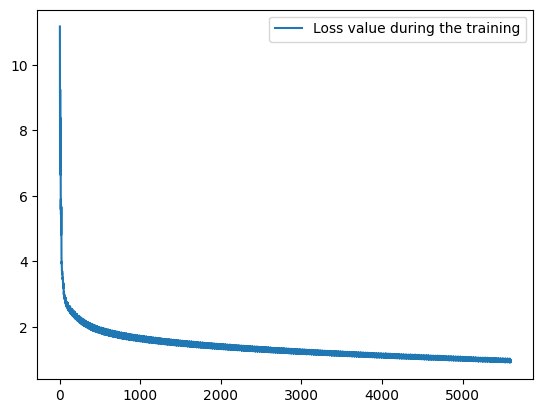

In [34]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

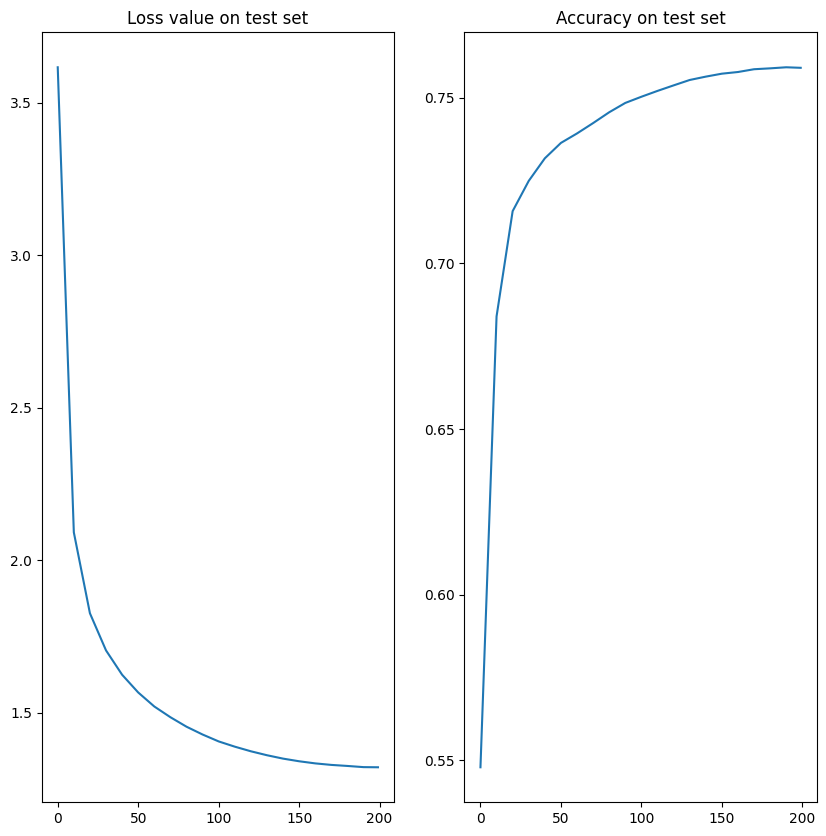

In [35]:
epochs = [epoch for epoch in range(num_epochs) if (epoch % test_every_epoch) == 0 or (epoch == num_epochs - 1)]

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on test set")
axs[0].plot(epochs, eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on test set")
axs[1].plot(epochs, eval_metrics_history["test_accuracy"])

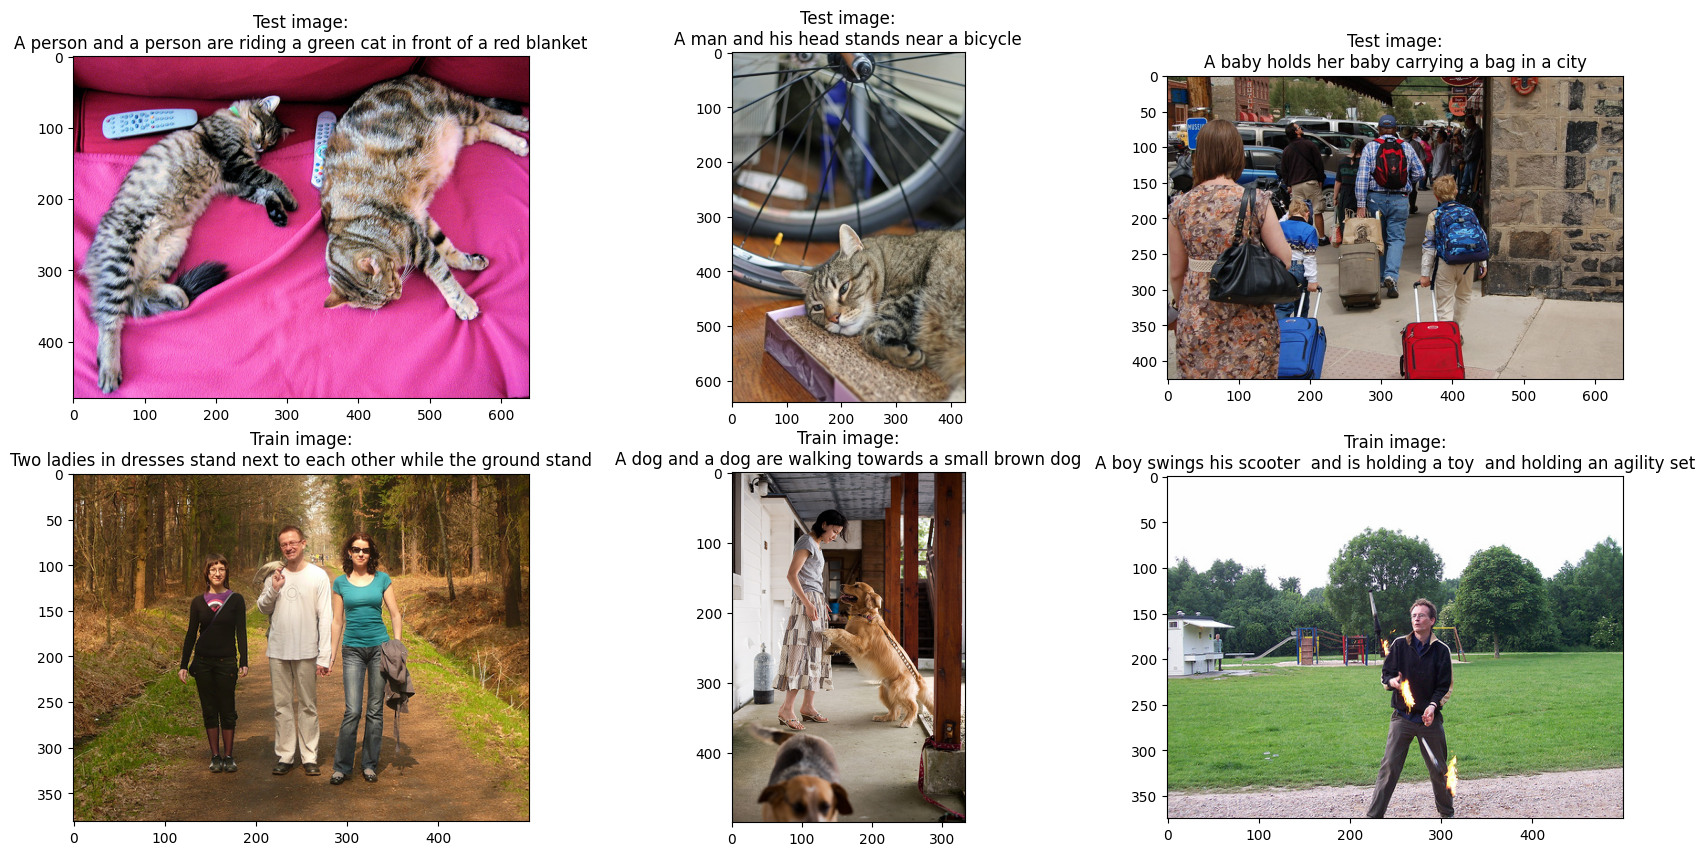

In [47]:
url1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
url2 = "https://farm2.staticflickr.com/1152/1151216944_1525126615_z.jpg"
url3 = "http://farm7.staticflickr.com/6206/6123723223_4113967b1e_z.jpg"

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, (prefix, pil_image) in enumerate([
    ("Test image", Image.open(requests.get(url1, stream=True).raw)),
    ("Test image", Image.open(requests.get(url2, stream=True).raw)),
    ("Test image", Image.open(requests.get(url3, stream=True).raw)),
    ("Train image", train_dataset[35]["image"]),
    ("Train image", train_dataset[45]["image"]),
    ("Train image", train_dataset[75]["image"]),
]):
    caption = model.generate(pil_image, max_length=max_length)

    x = i // 3
    y = i % 3
    axs[x, y].imshow(pil_image)
    axs[x, y].set_title(f"{prefix}:\n{caption}")

## Further reading

In this tutorial we implemented and trained a transformer-based model for image captioning task. We used a pretrained frozen Vision Transformer encoder and trained a small decoder to predict the next token. Observed generation capabilities of the trained model are not great. Next steps could be (1) to use larger decoder, (2) to unfreeze few top encoder layers, (3) try other decoder architectures.

- Freezing model's parameters using trainable parameters filtering: [example 1](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/training/optimizer.html#flax.nnx.optimizer.Optimizer.update) and [example 2](https://github.com/google/flax/issues/4167#issuecomment-2324245208).
- Other Computer Vision tutorials in [jax-ai-stack](https://jax-ai-stack.readthedocs.io/en/latest/getting_started.html).
- [LLM pretraining for text generation](https://jax-ai-stack.readthedocs.io/en/latest/JAX_for_LLM_pretraining.html).